In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

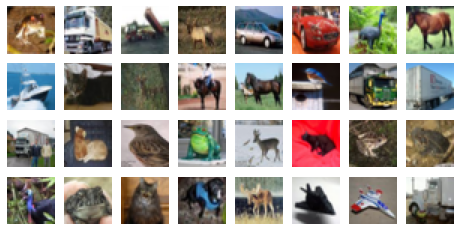

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

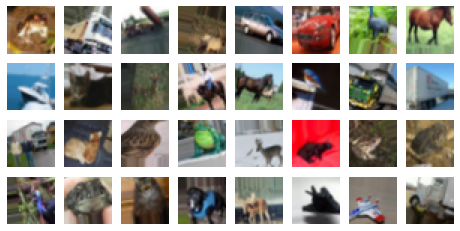

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

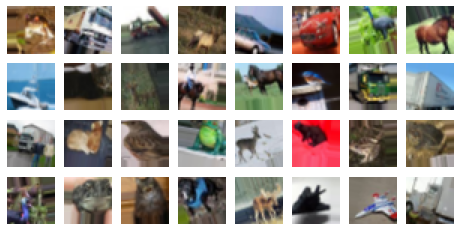

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [9]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 20 # 訓練的 epochs 數量

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [11]:
def build_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()
    
    return model

In [12]:
datagen = {}
datagen["rotation"] = ImageDataGenerator(rotation_range=20)
datagen["shift"] = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
datagen["h_flip"] = ImageDataGenerator(horizontal_flip=True)
datagen["all"] = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True)

optimizer = {}
optimizer["RMSprop"] = RMSprop()
optimizer["Adam"] = Adam()

In [14]:
import itertools
results = {}

for opt, para in itertools.product(optimizer.keys(), datagen.keys()):
    exp_name_tag = ("exp-%s-%s" % (opt, para))
    print("===", exp_name_tag, "===")
    model = build_CNN()
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer[opt],
              metrics=['accuracy'])  
    history = model.fit_generator(datagen[para].flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                        steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    # Collect results    
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])



=== exp-RMSprop-rotation ===
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)        

Epoch 1/20
390/390 [==============================] - 52s 132ms/step - loss: 1.9142 - accuracy: 0.3008 - val_loss: 1.5897 - val_accuracy: 0.4351
Epoch 2/20
390/390 [==============================] - 50s 128ms/step - loss: 1.5842 - accuracy: 0.4257 - val_loss: 1.3661 - val_accuracy: 0.5064
Epoch 3/20
390/390 [==============================] - 36s 91ms/step - loss: 1.4266 - accuracy: 0.4885 - val_loss: 1.0865 - val_accuracy: 0.6167
Epoch 4/20
390/390 [==============================] - 42s 107ms/step - loss: 1.3281 - accuracy: 0.5252 - val_loss: 1.0432 - val_accuracy: 0.6259
Epoch 5/20
390/390 [==============================] - 43s 109ms/step - loss: 1.2469 - accuracy: 0.5586 - val_loss: 0.9814 - val_accuracy: 0.6486
Epoch 6/20
390/390 [==============================] - 50s 128ms/step - loss: 1.1794 - accuracy: 0.5831 - val_loss: 0.9867 - val_accuracy: 0.6490
Epoch 7/20
390/390 [==============================] - 49s 124ms/step - loss: 1.1223 - accuracy: 0.6035 - val_loss: 0.8733 - val_acc

390/390 [==============================] - 19s 48ms/step - loss: 0.6688 - accuracy: 0.7748 - val_loss: 0.6615 - val_accuracy: 0.7842
Epoch 19/20
390/390 [==============================] - 19s 48ms/step - loss: 0.6657 - accuracy: 0.7771 - val_loss: 0.6343 - val_accuracy: 0.8075
Epoch 20/20
390/390 [==============================] - 20s 51ms/step - loss: 0.6664 - accuracy: 0.7779 - val_loss: 0.6009 - val_accuracy: 0.8013
Test loss: 0.6008572257041931
Test accuracy: 0.8012999892234802
=== exp-RMSprop-all ===
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_____

Epoch 1/20
390/390 [==============================] - 44s 113ms/step - loss: 1.6375 - accuracy: 0.4005 - val_loss: 1.3688 - val_accuracy: 0.4990
Epoch 2/20
390/390 [==============================] - 33s 84ms/step - loss: 1.2920 - accuracy: 0.5352 - val_loss: 1.0895 - val_accuracy: 0.6118
Epoch 3/20
390/390 [==============================] - 37s 96ms/step - loss: 1.1455 - accuracy: 0.5936 - val_loss: 0.9866 - val_accuracy: 0.6474
Epoch 4/20
390/390 [==============================] - 43s 111ms/step - loss: 1.0492 - accuracy: 0.6274 - val_loss: 1.0027 - val_accuracy: 0.6456
Epoch 5/20
390/390 [==============================] - 48s 123ms/step - loss: 0.9858 - accuracy: 0.6533 - val_loss: 0.8873 - val_accuracy: 0.6889
Epoch 6/20
390/390 [==============================] - 48s 124ms/step - loss: 0.9354 - accuracy: 0.6708 - val_loss: 0.8014 - val_accuracy: 0.7188
Epoch 7/20
390/390 [==============================] - 47s 119ms/step - loss: 0.8846 - accuracy: 0.6888 - val_loss: 0.7765 - val_accu

Epoch 18/20
390/390 [==============================] - 48s 124ms/step - loss: 2.3027 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 19/20
390/390 [==============================] - 45s 115ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 20/20
390/390 [==============================] - 45s 114ms/step - loss: 2.3027 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Test loss: 2.3025991916656494
Test accuracy: 0.10000000149011612
=== exp-Adam-h_flip ===
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 30, 30, 32)        

Epoch 1/20
390/390 [==============================] - 52s 134ms/step - loss: 1.9816 - accuracy: 0.2551 - val_loss: 1.7107 - val_accuracy: 0.3760
Epoch 2/20
390/390 [==============================] - 52s 134ms/step - loss: 1.7888 - accuracy: 0.3273 - val_loss: 1.5751 - val_accuracy: 0.4193
Epoch 3/20
390/390 [==============================] - 52s 134ms/step - loss: 1.6787 - accuracy: 0.3766 - val_loss: 1.5159 - val_accuracy: 0.4436
Epoch 4/20
390/390 [==============================] - 52s 133ms/step - loss: 1.6141 - accuracy: 0.4062 - val_loss: 1.4705 - val_accuracy: 0.4560
Epoch 5/20
390/390 [==============================] - 52s 134ms/step - loss: 1.5737 - accuracy: 0.4206 - val_loss: 1.3862 - val_accuracy: 0.4943
Epoch 6/20
390/390 [==============================] - 53s 137ms/step - loss: 1.5298 - accuracy: 0.4392 - val_loss: 1.4457 - val_accuracy: 0.4771
Epoch 7/20
390/390 [==============================] - 53s 137ms/step - loss: 1.5030 - accuracy: 0.4495 - val_loss: 1.3012 - val_ac

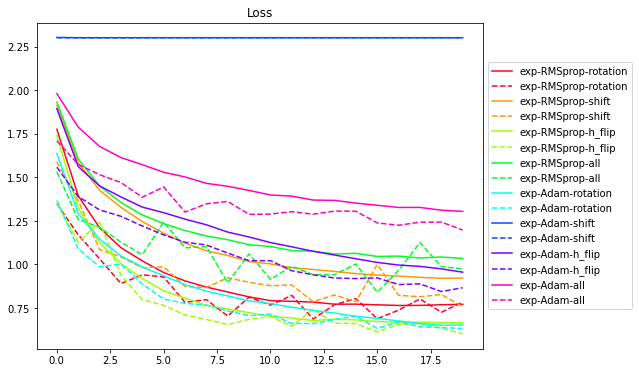

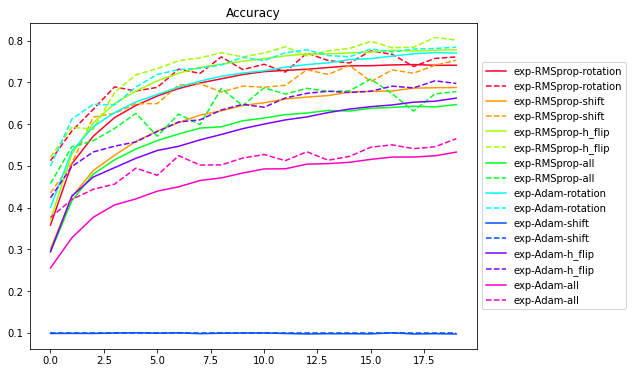

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()